# Обновляем Fast AI

In [0]:
!curl -s https://course.fast.ai/setup/colab | bash
# Проверяем версию
from fastai.version import __version__; __version__

Документация по фреймворку Fast AI по работе с текстом: https://docs.fast.ai/text.html

Импортируем необходимые модули

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.text import *
import os
from tqdm import tqdm_notebook

# Подготавливаем данные

Сохраните данные для обучени и модели на свой Google-диск:

https://drive.google.com/open?id=1rKZLehhvsveyYQoTFreZ3DtQPyaRkXUL


Монтируем Google Drive в Google Colab

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = '/content/gdrive/My Drive'

Проверяем, что на Google Drive появилась расшаренная папка `itis-fast-ai-text`

In [0]:
! ls '/content/gdrive/My Drive/itis-fast-ai-text'

Копируем данные с Google диска на локальный диск виртуальной машины

In [0]:
! cp -r '/content/gdrive/My Drive/itis-fast-ai-text' ml 

Определяем корневой путь, с которым будем работать

In [0]:
ROOT_PATH = Path('/content/ml')

In [0]:
list(ROOT_PATH.iterdir())

In [0]:
DATA_PATH = ROOT_PATH/'kinopoisk'/'data'

In [0]:
list(DATA_PATH.iterdir())

### Читаем данные отзывов с помощью Pandas

In [0]:
names = ['valid', 'train']
df_val, df_trn = [pd.read_json(DATA_PATH/f'{name}_reviews.json', lines=True) for name in names]

Посмотрим, что внутри

In [0]:
df_val.head()

Размеры тренировочной и валидационной выборок

In [0]:
df_trn.shape, df_val.shape

In [0]:
df_val['valid'] = True
df_trn['valid'] = False
df_all = pd.concat((df_trn, df_val))

In [0]:
df_all.shape

# Языковая модель

## Подготовка данных

**BatchSize** - основной гиперпараметр сети, определяющий кол-во одновременно обрабатываемых обучающих примеров

In [0]:
bs = 32

Загружаем словарь

In [0]:
vocab = Vocab.load(ROOT_PATH/'kinopoisk'/'models'/'kinopoisk_lm_vocab.pkl')

Определяем набор данных, с помощью читабельного fluent-api:

In [0]:
data = TextList.from_df(df_all, cols='reviewBody',
                        processor=[TokenizeProcessor(tokenizer=Tokenizer(lang="xx")), 
                                   NumericalizeProcessor(vocab=vocab)]).\
                split_from_df('valid').\
                label_for_lm().\
                databunch(bs=bs)

Сохраняем данные для того, чтобы в следующий раз не приходилось заново обрабатывать текст

In [0]:
data.save(DATA_PATH / "kinopoisk_lm_data.pkl")

In [0]:
data = load_data(DATA_PATH, "kinopoisk_lm_data.pkl", bs)

### Посмотрим как выглядят данные

In [0]:
data.show_batch()

Каждому слову -(токену) ставится в соответсвии порядковый номер из словаря

In [0]:
data.vocab.itos[:17]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 ',',
 '.',
 'и',
 'в',
 'не',
 '\r \n \r \n ',
 '-',
 'что']

xxunk, xxpad и тд - это специальные токены, для представления текста.
Например, токен **xxmaj** показывает, что следующее слово в исходном тексте начинается с большой буквы.

Каждому токену соответсвует число из словаря:

In [0]:
data.train_ds[0][0].data

array([  2,   5,  28, 210, ..., 273, 145, 189,  10])

Задача нейронной сети при обучении языковой модели - предсказать наиболее вероятное слово, идущее после данной последовательности слов.

## Обучение модели

Используемая архитектура сети - реализация [AWD-LSTM](https://arxiv.org/abs/1708.02182) (Average SGD Weights Dropped LSTM)

In [0]:
# Если мы обрабатываем тексты на английском языке, то Fast AI имеет предобученную на Википедии модель
# learn = language_model_learner(data, arch=AWD_LSTM)

Мы воспользуемся предобученной моделью на корпусе текстов "Тайга".

Веса модели взяты взята отсюда: https://github.com/mamamot/Russian-ULMFit

Корпус текстов Тайга: https://tatianashavrina.github.io/taiga_site/

**Дополнительно**

Как обучить языковую модель на википедии: https://github.com/ademyanchuk/ulmfit-multilingual

Обсуждение темы на форуме Fast AI: https://forums.fast.ai/t/ulmfit-russian/36312



In [0]:
learn = language_model_learner(data, arch=AWD_LSTM, pretrained=False, pretrained_fnames=('lm_5_ep_lr2-3_5_stlr', 'itos'), path=ROOT_PATH/'russian_lm')


Проверим, как работает модель

In [0]:
TEXT = "Британские ученые обнаружили"
N_WORDS = 60
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.8) for _ in range(N_SENTENCES)))

In [0]:
TEXT = "Вчера рано утром в Москве"
N_WORDS = 60
N_SENTENCES = 2

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

In [0]:
# Введите текст:
TEXT = ""
N_WORDS = 60
N_SENTENCES = 2

### Поиск оптимального шага обучения

Перед тем как приступить к обучению языковой модели, мы должно найти оптимальный learning_rate (lr) - это гиперпараметр, который определяет с какой скоростью будет обучаться модель

In [0]:
learn.lr_find()

На графике нам нужно выбрать наибольший LR такой, что Loss (функцию потерь) еще достаточно быстро уменьшается. Мы выберем 10e-2. 

In [0]:
learn.recorder.plot(skip_end=15)

### ВНИМАНИЕ!!! Обучение языковой модели занимает часы!

Так как часть слов в словаре новые и сеть про них ничего не знает, то мы начнем обучать только последний слой и embedding-и новых слов

In [0]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.623338,4.057502,0.228571,29:25


Сохраняем модель

In [0]:
learn.save('kinopoisk_head')

In [0]:
learn.load('kinopoisk_head')

Посмотрим из каких слоев состоит нейронная сеть

In [0]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60004, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60004, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60004, bias=True)
    (output_dp): RNNDropout()
  )
)

In [0]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1150]           0          False     
______________________________________________________________________
RNNDropout           [70, 1150]           0          False     
______________________________________________________________________
Linear               [70, 60004]          24,061,604 True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 24,061,604
Total trainable params: 24,061,604
Total non-trainable params: 0

Теперь мы "размораживаем" все слои и продолжим обучение языковой модели

In [0]:
learn.unfreeze()

In [0]:
from fastai.callbacks import SaveModelCallback

In [0]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8, 0.7), 
                    callbacks=[SaveModelCallback(learn, name='best_kinopoisk')])

epoch,train_loss,valid_loss,accuracy,time
0,4.374048,3.758804,0.300000,33:44
1,4.262966,3.546897,0.328571,33:48
2,4.226732,3.489769,0.371429,33:50
3,4.159681,3.341416,0.385714,33:52
4,4.098773,3.390381,0.371429,33:54
5,4.072806,3.288219,0.385714,33:53
6,4.043604,3.259739,0.371429,33:55
7,3.992717,3.264781,0.400000,33:54
8,3.968031,3.251725,0.371429,33:55
9,3.943636,3.248332,0.385714,33:54


Better model found at epoch 0 with val_loss value: 3.7588043212890625.
Better model found at epoch 1 with val_loss value: 3.5468966960906982.
Better model found at epoch 2 with val_loss value: 3.489769220352173.
Better model found at epoch 3 with val_loss value: 3.341416358947754.
Better model found at epoch 5 with val_loss value: 3.2882192134857178.
Better model found at epoch 6 with val_loss value: 3.2597389221191406.
Better model found at epoch 8 with val_loss value: 3.251725435256958.
Better model found at epoch 9 with val_loss value: 3.2483322620391846.


In [0]:
learn.save('kinopoisk_tuned')

In [0]:
learn.load('kinopoisk_tuned');

Качество языковой модели измеряется такой метрикой, как перплексия. В данном случае ее можно посчитать, если взять экспоненту от величины функции потерь на валидационной выборке. Чем меньше перплексия, тем лучше

In [0]:
np.exp(3.248332)

25.74735748752309

Сохраняем Encoder

In [0]:
learn.save_encoder('kinopoisk_tuned_enc')

## Загружаем предобученную модель

А теперь загрузим уже обученную на отзывах модель и поэкспериментируем с ней

In [0]:
learn = language_model_learner(data, arch=AWD_LSTM, pretrained=False, pretrained_fnames=('kinopoisk_tuned', 'kinopoisk_lm_vocab'), path=ROOT_PATH/'kinopoisk')

Посмотрим как работает предсказание

In [61]:
TEXT = "полный эффект присутствия"
N_WORDS = 60
N_SENTENCES = 2

print(u"\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75).replace('\r', '') for _ in range(N_SENTENCES)))

 
 
  Потрясающая история любви , которая не отпускает ни на минуту . в этом фильме нет ни одного лишнего момента , кроме секса , и все эти моменты показаны
полный эффект присутствия . Если Вы ждали чего - то большего , чем просто Мстители , то , по правде говоря , идея о том , что Мстители и Мстители не могут быть добрыми , это было бы глупо , но ведь Мстители , Черная вдова и Халк , очень похожи на Железного


In [0]:
TEXT = "Мрачный, жестокий фильм с"
N_WORDS = 60
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75).replace('\r', '') for _ in range(N_SENTENCES)))

In [0]:
TEXT = "На самом деле в этом"
N_WORDS = 90
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75).replace('\r', '') for _ in range(N_SENTENCES)))

In [0]:
TEXT = "могло быть и"
N_WORDS = 90
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75).replace('\r', '') for _ in range(N_SENTENCES)))

In [0]:
TEXT = "самый настоящий провал"
N_WORDS = 60
N_SENTENCES = 2

print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75).replace('\r', '') for _ in range(N_SENTENCES)))

# Классификация отзывов с Кинопоиска

## Подготовка данных

In [0]:
bs = 48


Важно, чтобы словарь, используемый для классификатора, 
в точности **совпадал со словарем**, который использовалася на этапе обучения **языковой модели**

In [0]:
vocab = Vocab.load(ROOT_PATH/'kinopoisk'/'models'/'kinopoisk_lm_vocab.pkl')

In [0]:
# если у вас уже загрузены данные языковой модели, то можно сделать
# vocab = data.vocab

In [0]:
data_clas = (TextList.from_df(df_all, cols='reviewBody', vocab=vocab)
             .split_from_df('valid')
             .label_from_df(cols='status')
             .databunch(bs=bs))

In [0]:
data_clas.save(DATA_PATH/'kinopoisk_clas_data.pkl')

In [0]:
data_clas = load_data(DATA_PATH, "kinopoisk_clas_data.pkl", bs)

А теперь создадим классификатор

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, path=ROOT_PATH/'kinopoisk', pretrained=False)
# Загружаем предварительно обученный encoder
learn.load_encoder('kinopoisk_tuned_enc')

## Обучаем классификатор

Пожалуйста, найдите оптимальный learning rate и обучите модель один цикл этим learning rate с параметром `moms=(0.8, 0.7)`

Сохраните полученную модель под именем 'kp_first'

А теперь мы продолжаем размораживать слои, обучая их "по очереди", начиная с конца.

Мы не хотим сразу разрушить хрупкую структуру Encoder-a, который был обучен на предыдущем шаге.

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(3e-2/(2.6**4),3e-2), moms=(0.8,0.7))

In [0]:
learn.save('kp_second')

In [0]:
learn.load('kp_second');

Продолжаем обучать модель, размораживая следующие слои

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.141272,0.106738,0.960053,06:24


In [0]:
learn.save('kp_third')

In [0]:
learn.load('kp_third');

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.111156,0.106131,0.958189,08:03


Мы натренировали нашу сеть, которая **с высокой точностью (96%)** определяет "тональность" отзыва

Можно загрузить уже обученный заранее классификатор:

In [0]:
learn.load('kinopoisk_clas_tuned');

Давайте проверим ее на случайном отызыве с кинопоиска

In [0]:
# Пример положительного отзыва

learn.predict('''
«Балканский рубеж» в некотором роде уникальный фильм для нашего синематографа последнего времени. И вот почему, с одной стороны мы снимаем по лекалам телефильмов о доблестном спецназе кино, которое при прочих равных прошло бы более или менее не замеченным, а с другой стороны обозначаем проблему сосуществования народов и этнических войн на территории бывшей Югославии. К данной теме я вообще не равнодушен и было интересно взглянуть, как отечественный режиссер покажет эти моменты. И получилось совсем не плохо, по крайней мере, у меня не возникает чувства непонимания, что происходило в Боснии и Косово. Да, широкими мазками обозначена проблема, зато доходчиво донесено, что испытывали простые люди при развале страны. 

После конфликта во взаимодействии с силами НАТО, члены разведовательно — диверсионной группы оказываются в непростой ситуации и вынуждены остаться вне пределов России. Каждый устраивается по своему в новой жизни и старается выжить. Но изменение вектора политической обстановки вновь делает их востребованными Отечеством. Надо занять и удержать аэропорт Приштины в Косово, до подхода российских миротворцев. Захват и удержание показаны в добротной манере отечественных сериалов, останавливаться на этом не буду, меня больше порадовали второстепенные линии сюжета. Возможно, сотрудничество с сербами сделали эти линии проникновенными с чисто человеческого восприятия. Это и драма в роддоме при налетах НАТО, и непростые отношения косоваров и сербов на примере полицейского поста в Косово, и этническо — конфессиональные расстрелы, и напряжение до срывов медработников от вида пострадавших — говорят война все спишет, это так. Только вот рубцов и ран в душах людей не излечит даже время, боль и горечь потерь близких и друзей долго будет жить в памяти. 

Переплетение реальных фактов и художественного вымысла неплохо сочеталось в этой ленте — марш-бросок на Приштину десантников удачно дополнил бой группы Бека, восторги сербов на кадрах хроники и киношные смотрелись органично. Что касается политических перипетий, то это дело грязное и идеологический контекст можно и пропустить при просмотре, хотя ничего нереального в показанном я не увидел. Порадовали показанные будни десантников, под «Сектор газа» смотрелось реалистично, вполне реальное развлечение для отвлечения от повседневной рутины.

Актеры сыграли в целом нормально и наши и сербские, из наших мне понравились Куркова, Полухин и Марин, из сербов Гойко Митич, Бикович и Родойичич. Специфический юмор только усилил игру актеров. Кустурица в концовке тоже смотрелся к месту. В целом, не проявив чудес актерского мастерства все смотрелись не плохо. 

Минусы конечно есть и довольно жирные, в основном связаны с навязыванием определенного идеологического подтекста, и увы, незнанием особенностей службы в войсках специального назначения. Но в целом фильм они не уродуют, поэтому смело отношу его к положительным моментам нашего кинопроката.
''')

In [0]:
# Пример отрицательного отзыва

learn.predict('''
Пусть видят, кто против них (с)

В конце 90-ых, во время очередного конфликта между сербами и албанцами, российская спецгруппа, находящаяся на территории Югославии, получает приказ захватить местный аэропорт и удержать его до прихода наших миротворцев.

Режиссер «Танцев насмерть» и «Спирали», посредственных, никому ненужных картин, Андрей Волгин на западе давно бы оказался у разбитого корыта и пошел бы на прорыв, получив последний шанс или вошел бы в какую-нибудь когорту создателей сериалов, где ты просто один из тех, кто визуализирует чужие идеи. У нас же все совершенно по-другому произошло… Волгин получил большой бюджет, материал и не самых последних актеров, и что же он из этого смастерил? Все самое наипростейшее… Мотивы героев, как и предсказуемость сюжетных ходов и выпрыгивания спецэффектов из-за ушла — все это уже миллион раз использованные другими ходы, причем и реализованные сверхстандартно и стерильно. Ведь если у тебя есть антагонист, то кроме как дать ему нож и возможность оправдать рейтинг 16+ — единственный вариант продемонстрировать его характер и жестокость. Так же и с другими героями, один поет, другой постоянно про пенсию говорит, третий хочет денег, а узбечка заглянула на проект в поисках мужика, так и работают. А зрителям еще нужно разбираться причем тут НАТО, кто виноват и что делать, в общем не считая плохих дорог здесь есть все классические вопросы, волнующие русских на протяжении веков.

По какой-то совершенно непонятной причине главную роль в «Балканском рубеже» исполнил Антон Пампушный («Защитники») — парень, конечно, колоритный, но с одной эмоцией на лице на любое происшествие и действие в его (их) сторону. Странно видеть таким потерянным Милоша Биковича («Лед»), у него здесь ключевая драматическая роль, но он так все это преподносит, что хочется снять ему скальп ничуть не меньше, чем террористам, которые гоняются за ним. Красивую Милену Радулович («Однажды летней ночью») при любой возможности раздевают, а героиня Равшаны Курковой («Без границ») получилась не только крутой, но еще и с юморком. Одного из самых запоминающихся бойцов с нашей стороны сыграл Сергей Марин («Анна-детективъ»), его неоднозначности и крутости, могли бы позавидовать и заграничные коллеги. Для увесистости в фильм влились: Гоша Куценко («Параграф 78»), которому очень нравится собирать себе отряды, любимейший югослав старшего поколения Гойко Митич («Апачи») и вечный Эмир Кустурица («Время цыган»). 

Картина «Балканских рубеж» очевидно снята явно из хороших побуждений и желания сделать, что-то свое на уровне Бэя и его «13 часов». Главные герои — такие наши Джеймсы Бонды без фантастической составляющей. Но вот снят «Балканский рубеж» самым скучным и потребительским образом: с кучей слоу-мо, увидев его количество даже создатели «Т-34» тихо стоят и покуривать в сторонке, хотя попытку сыграть в масштаб и серьезность можно и зачесть. Правда дешевые спецэффекты и длиннющие диалоги с попыткой хоть как-то раскрыть героев портят этот и так слишком затянутый фильм с нелогичным кастингом и музыкой, которая убаюкивает зрителей постоянно повторяющимся мотивом.''')

In [0]:
learn.predict('Очень хороший фильм')

In [0]:
learn.predict('Почему то мне кажется, что фильм далек от идеала. Я бы не советовал его смотреть')

In [0]:
learn.predict('''
              Фильм показался мне ужасным.
              Это невероятное чувство плохой игры актеров.
              Не рекомендую смотреть
              ''')

Экспериментируйте!

In [0]:
learn.predict("Лучший фильм, который я когда-либо смотрел!")

In [0]:
learn.predict("Это худший фильм, который я когда-либо смотрел. Такие дела. Хотя может быть и стоит посмотреть фанатам")

## Интерпритируем результаты работы

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
losses,idxs = interp.top_losses()

len(data_clas.valid_ds)==len(losses)==len(idxs)

Пары классов, которые сеть путает больше всего

In [0]:
interp.most_confused()

Посмотрим на матрицу ошибок:

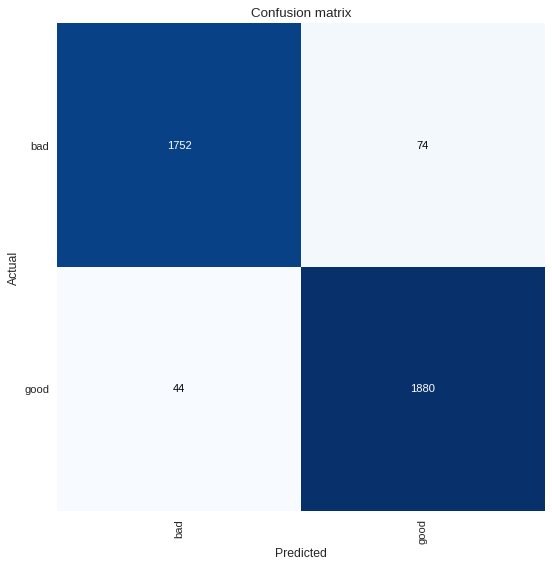

In [0]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=80)

In [0]:
learn.predict('Это ужасный фильм. И как это я мог такое смотреть? Крайне не рекомендую')

(Category bad, tensor(0), tensor([9.9927e-01, 7.3213e-04]))